In [1]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl
import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline 

%load_ext autoreload                                                              
                                                                                                                                  
%autoreload 

In [2]:
                                                                                                                                                                                                                        
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
if not os.path.isdir('Spectralplot_images'):
    os.makedirs('Spectralplot_images')


In [4]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum( x**2,0 )[:,None] + np.sum( y**2,0 )[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter( x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2 )

In [5]:
def generate_data(N):
    """
     N is a list of the size of the data on x and y
    """
    x = np.random.rand( 2,N[0] )-0.5
    theta = 2*np.pi*np.random.rand( 1,N[1] )
    r = 0.8+.2*np.random.rand( 1,N[1] )
    y = np.vstack( ( r*np.cos( theta ),r*np.sin( theta ) ) )
    return x,y

In [6]:
def spectral_decomposition(mat):
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])

    return eig,v



In [7]:
def precondition_matrix(matrix, precond_vectors,null_vector):
    diag   = 1/np.sqrt(np.diag( matrix ).flatten())
    matrix = diag[:,None]*matrix*diag[None,:]

    vector = null_vector
    vector = vector/diag
    vector = vector/np.linalg.norm( vector )
    vector = vector.reshape( (len( vector ), 1) )
    matrix = matrix + np.dot( vector, vector.T )
    k = len( precond_vectors )
    n = null_vector.shape[0]
    y = np.array( precond_vectors ).T # Matrix of size n by k
    # Compute eigenvalues
    Ay = np.dot( matrix, y )
    eigenvalues = np.sum( y * Ay, axis=0 )
    # Compute P_matrix = id + y*diag(values)*y.T
    values = ( 1/np.sqrt(eigenvalues)-1 )    # Vector of size k
    z = y*values[None,:]
    P_matrix = np.identity( n ) + np.dot( z, y.T )
    B = np.dot( Ay, z.T )
    C = z @ np.dot( y.T, Ay ) @ z.T
    matrix = matrix + B + B.T + C
    return matrix



In [8]:
import computational_OT

In [9]:
N = [ 500, 600 ]
x,y = generate_data(N)

### Log-domain Sinkhorn 

In [10]:
a = normalize(np.ones(N[0]))
b = normalize(np.ones(N[1]))
# Log domain Sinkhorn
print("Log domain Sinkhorn.... ")
results_logSinkhorn = []
times_logSinkhorn   = []
logsinkhornP        = []
epsilons = [ 0.1 , 0.05 , 0.01, 0.005,  0.001]
# epsilons = [1.0]

# epsilons = [ 0.5, 0.3, 0.1, 0.09, 0.05, 0.03, 0.02, 0.001]
# epsilons = [1.0]
#Cost matrix
C = distmat(x,y)
for eps in epsilons:

  print( "Sinkhorn for epsilon = "+str(eps)+":" )    
  



  print( "Doing for (",N[0],N[1],")." )
  print( " |- Iterating" )

  start = time.time()
  logsinkhorn = computational_OT.Log_domainSinkhorn(a,b,C,eps)
  output = logsinkhorn.update( niter = 500 )
  results_logSinkhorn.append( output )
  end = time.time()
  times_logSinkhorn.append(1e-3*(end-start) )
  logsinkhornP.append(GetP(output['potential_f']/eps, np.exp(-C/eps),output['potential_g']/eps))

Log domain Sinkhorn.... 
Sinkhorn for epsilon = 0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  147
Sinkhorn for epsilon = 0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  302
Sinkhorn for epsilon = 0.01:
Doing for ( 500 600 ).
 |- Iterating
Sinkhorn for epsilon = 0.005:
Doing for ( 500 600 ).
 |- Iterating
Sinkhorn for epsilon = 0.001:
Doing for ( 500 600 ).
 |- Iterating


#### Error plot

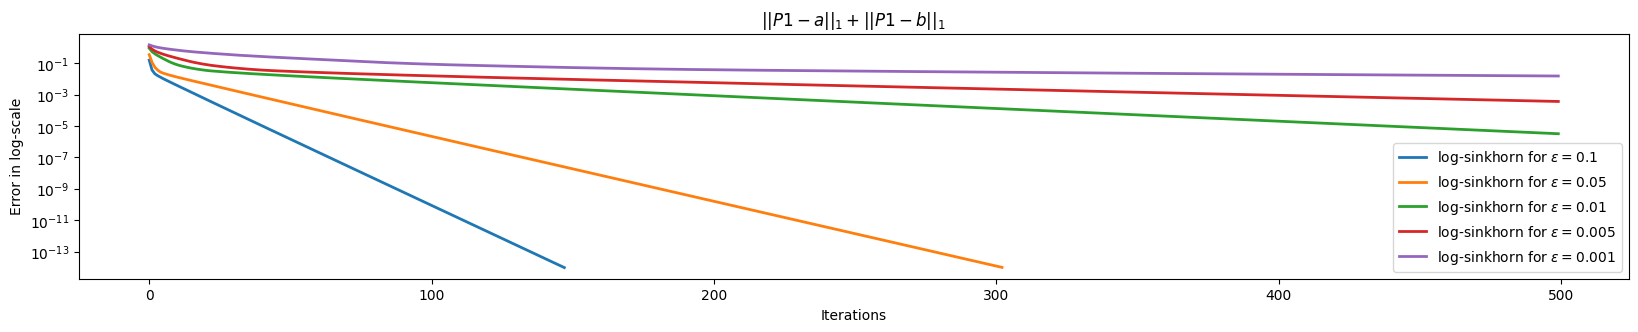

In [11]:
plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len( results_logSinkhorn) ):
  error = np.asarray( results_logSinkhorn[i]['error'] )
  plt.plot( error, label = 'log-sinkhorn for $\epsilon=$'+ str(epsilons[i]) , linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")
plt.show()


In [12]:
flogsinkhorn, glogsinkhorn = [], []
for i in range(len(results_logSinkhorn)):
    flogsinkhorn.append(results_logSinkhorn[i]['potential_f'])
    glogsinkhorn.append(results_logSinkhorn[i]['potential_g'])

#### Spectral plot

##### Forming the unnormalised Hessian

In [13]:
Hessians_logsinkhorn = []
for i in range(len(epsilons)):
    u  = np.exp((results_logSinkhorn[i]['potential_f'])/epsilons[i])  
    v  = np.exp((results_logSinkhorn[i]['potential_g'])/epsilons[i])
    K  = np.exp(-C/epsilons[i])
    r1 = u[:,None]*np.dot(K,v)[:,None] 
    r2 = v[:,None]*np.dot(K.T,u)[:,None]                                
    P  = u[:,None]*np.exp(-C/epsilons[i])*v[None,:]
    A  = np.diag( np.array(r1.reshape(r1.shape[0],)) )
    B  = P       
    C_  = P.T
    D  = np.diag( np.array(r2.reshape(r2.shape[0],)) )
    result = np.vstack( ( np.hstack((A,B)), np.hstack((C_,D)) ) )    
    Hessians_logsinkhorn.append(result)

In [14]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    diag   = 1/np.sqrt(np.diag( Hessians_logsinkhorn[i] ).flatten())
    result = diag[:,None]*Hessians_logsinkhorn[i]*diag[None,:]
    ev = spectral_decomposition( result )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [-1.10488672e-15  9.25797263e-02  1.01062875e-01  2.70738661e-01
  3.23314694e-01  5.00338560e-01  5.08021851e-01  6.56911422e-01
  6.98637358e-01  7.99707848e-01]
List of largest  eigenvalues:  [1.20029215 1.30136264 1.34308858 1.49197815 1.49966144 1.67668531
 1.72926134 1.89893712 1.90742027 2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [6.60958382e-16 4.64399194e-02 5.08333883e-02 1.51439431e-01
 1.78363169e-01 3.04058582e-01 3.07099041e-01 4.28085186e-01
 4.69695068e-01 5.75400499e-01]
List of largest  eigenvalues:  [1.4245995  1.53030493 1.57191481 1.69290096 1.69594142 1.82163683
 1.84856057 1.94916661 1.95356008 2.        ]

Spectral statistics of Hessian for epsilon=0.01
List of smallest eigenvalues:  [-1.78386986e-16  9.22145899e-03  1.10310520e-02  3.38742470e-02
  4.03714767e-02  7.41065580e-02  7.43911798e-02  1.10346041e-01
  1.25299819e-01  1.655934

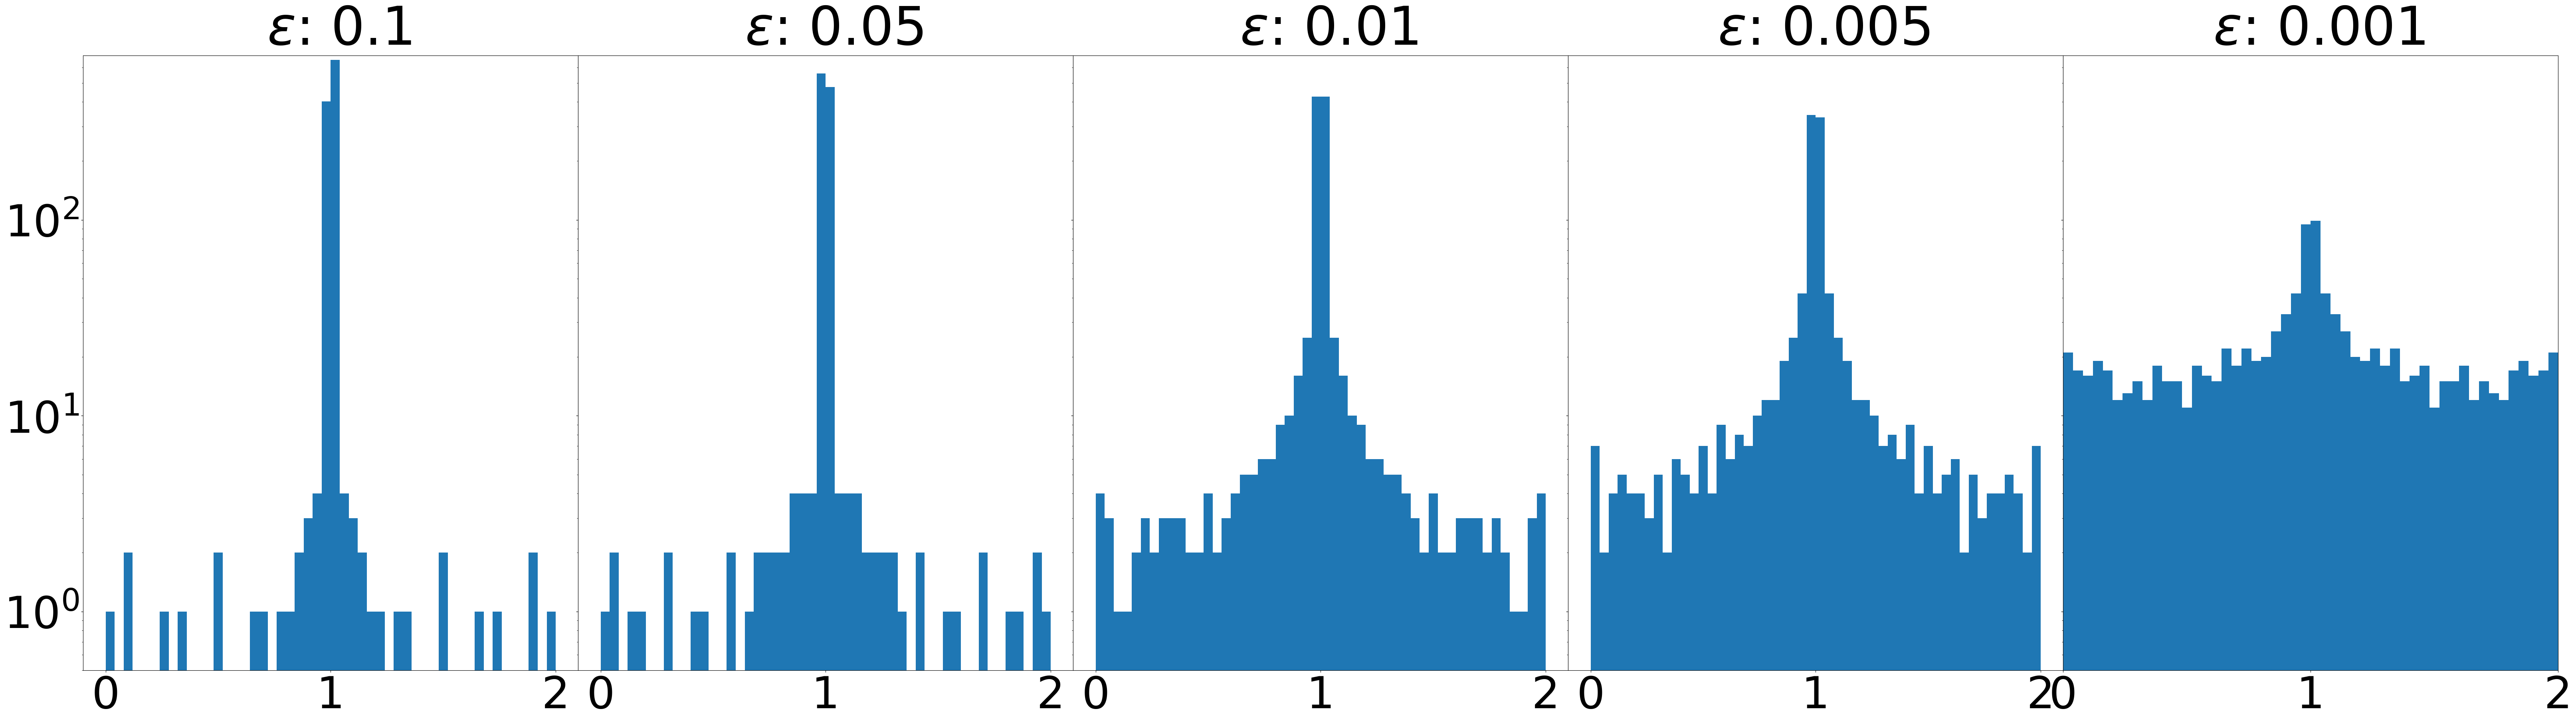

In [15]:
plt.rcParams.update({'font.size': 80})
fig,ax = plt.subplots(figsize = (80,20),nrows = 1, ncols = len(epsilons), sharey = True)
plt.title("Histogram of eigenvalues.")
plt.subplots_adjust(wspace=0,hspace=0)
p = np.log10(0.5)
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_ylim(ymin = 10**p)
    ax[i].set_yscale( "log" )   
plt.margins(0,0)
fig.savefig("Spectralplot_images/WithoutPreconditionedHistograms_LogSinkhorn.pdf",format='pdf',  bbox_inches='tight')
plt.show()

##### Spectral plots with preconditioning

In [16]:
def build_preconditioners( num_eigs,modified_Hessian, ansatz=True ):
    # Diagonalize
    eigenvalues, eigenvectors = np.linalg.eigh( modified_Hessian )
    sorting_indices = np.argsort( eigenvalues )
    eigenvalues  = eigenvalues[sorting_indices]
    eigenvectors = eigenvectors[:, sorting_indices]
    # Form null vector
    if not ansatz:
        null_vector = eigenvectors[:, 0]
    else:
        null_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        null_vector = null_vector/norm
    # Form other vectors (only 13)
    n,m = eigenvectors.shape
    indices=[]
    for i in range(num_eigs//2):
        indices.append(m-i-2)
        indices.append(i+1)
    if num_eigs%2!=0:
        indices.append(m-1-(num_eigs//2))
   
    precond_vectors = eigenvectors[:, indices ]
    precond_vectors = []
    for index in indices:
        precond_vectors.append( eigenvectors[:,index] )
    #
    return null_vector, precond_vectors

In [17]:
num_eigs = [ 50, 100, 200, 400, 800, 1098 ]
preconditioned_Hessians = {}
for numeigs  in  range(len(num_eigs)):
    preconditioned_Hessians[num_eigs[numeigs]] = []
    for i in  range(len(epsilons)):
        diag   = 1/np.sqrt(np.diag( Hessians_logsinkhorn[i] ).flatten())
        result = diag[:,None]*Hessians_logsinkhorn[i]*diag[None,:]
        null_vector, precond_vectors = build_preconditioners( num_eigs[numeigs], result, ansatz=False )
        # vector = null_vector
        # vector = vector/diag
        # vector = vector/np.linalg.norm( vector )
        # vector = vector.reshape( ( len( vector ), 1) )
        # result = result + np.dot( vector, vector.T )
        y_ = np.array( precond_vectors ).T # Matrix of size n by k
        # Compute eigenvalues
        Ay = np.dot( result, y_ )
        eigenvalues = np.sum( y_ * Ay, axis=0 )
        # Compute P_matrix = id + y*diag(values)*y.T
        values = ( 1/np.sqrt(eigenvalues)-1 )    # Vector of size k
        z = y_*values[None,:]
        B = np.dot( Ay, z.T )
        C_ = z @ np.dot( y_.T, Ay ) @ z.T
        result = result + B + B.T + C_
        preconditioned_Hessians[num_eigs[numeigs]].append( result )

In [18]:
eigs = {}
for numeigs in  range(len(num_eigs)):
    print("For number of preconditioning eigenvectors: ", num_eigs[numeigs])
    eigs[num_eigs[numeigs]] = []
    for i in range(len(epsilons)):
        eps = epsilons[i]
        print("Spectral statistics of Hessian for epsilon="+str(eps))
        ev = spectral_decomposition( preconditioned_Hessians[num_eigs[numeigs]][i])
        eigs[num_eigs[numeigs]].append(ev[0])
        print("")
    print("")

For number of preconditioning eigenvectors:  50
Spectral statistics of Hessian for epsilon=0.1


List of smallest eigenvalues:  [0.         0.9838805  0.98504711 0.99071518 0.99131068 0.99179706
 0.99252702 0.99342908 0.99381788 0.99457773]
List of largest  eigenvalues:  [1.00542227 1.00618212 1.00657092 1.00747298 1.00820294 1.00868932
 1.00928482 1.01495289 1.0161195  2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [-1.66533454e-16  9.08702918e-01  9.15273795e-01  9.34797640e-01
  9.41459512e-01  9.43477901e-01  9.45390346e-01  9.60903013e-01
  9.61400694e-01  9.63388176e-01]
List of largest  eigenvalues:  [1.03661182 1.03859931 1.03909699 1.05460965 1.0565221  1.05854049
 1.06520236 1.08472621 1.09129708 2.        ]

Spectral statistics of Hessian for epsilon=0.01
List of smallest eigenvalues:  [-6.35343292e-16  4.25987138e-01  4.44068063e-01  4.58214233e-01
  4.81551884e-01  4.95155865e-01  5.01631761e-01  5.07457676e-01
  5.32359915e-01  5.52365127e-01]
List of largest  eigenvalues:  [1.44763487 1.46764008 1.49254232 1.49836824 1.50

In [19]:
plt.rcParams.update({'font.size': 100})
fig,ax = plt.subplots(figsize = (120,130), nrows = len(num_eigs), ncols = len(epsilons), sharey = True, sharex = False)
plt.subplots_adjust(wspace=0,hspace=0.3)
p = np.log10(0.5)   
for numeigs in range(len(num_eigs)):
    for i in range(len(epsilons)):
        ax[numeigs][i].hist( eigs[num_eigs[numeigs]][i],50, rwidth = 0.9)
        ax[numeigs][i].set_title( " k = "+str(num_eigs[numeigs])+", $\epsilon$ = " +str(epsilons[i])+ "" )
        ax[numeigs][i].set_ylim(ymin = 10**p)
        ax[numeigs][i].set_yscale( "log" )  
                                    # ax[numeigs][i].set_xticks([0,1,2])
        # if numeigs == len(num_eigs):
        
        #     ax[numeigs][i].set_xlabel("Eigenvalues")
        #     ax[numeig``s][i].set_xticks([0,1,2])
ax[len(num_eigs)-1][len(epsilons)-1].set_xticks([0,1,2])

# plt.margins(0.019,0)    
fig.savefig("Spectralplot_images/PreconditionedHistograms_LogSinkhorn.pdf",format = 'pdf', bbox_inches="tight")
plt.show()


# Sinkhorn

In [20]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP = []
results_Sinkhorn = []
times_Sinkhorn = []
epsilons = [ 0.1 , 0.05 , 0.01, 0.005,  0.001]
Pmatrix_dist_linVSsinkhorn = []
 # a and b
a = normalize(np.ones(N[0]))
a = a.reshape(a.shape[0],-1)
b = normalize(np.ones(N[1]))
b = b.reshape(b.shape[0],-1)
#Cost matrix
C = distmat(x,y)
for eps in epsilons:

  
  print("Sinkhorn for epsilon: ", eps)


  #Kernel
  K = np.exp(-C/eps)


  print("Doing for (",N[0],N[1],").")
  print( " |- Iterating")

  #Inflating
  u = a
  v = b

  start     = time.time()
  Optimizer = computational_OT.Sinkhorn(K,a,b,u,v,eps)
  out       = Optimizer._update()
  results_Sinkhorn.append(out)
  end       = time.time()
  times_Sinkhorn.append(end-start)
  print( " |- Computing P")
  print( "" )
  SinkhornP.append(GetP(out['potential_f']/eps,K,out['potential_g']/eps))
  

Sinkhorn.... 
Sinkhorn for epsilon:  0.1
Doing for ( 500 600 ).
 |- Iterating


Terminating after iteration:  109
 |- Computing P

Sinkhorn for epsilon:  0.05
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  224
 |- Computing P

Sinkhorn for epsilon:  0.01
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1000
 |- Computing P

Sinkhorn for epsilon:  0.005
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1000
 |- Computing P

Sinkhorn for epsilon:  0.001
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  1000
 |- Computing P



In [21]:
fsinkhorn, gsinkhorn = [], []
for i in range(len(results_Sinkhorn)):
    fsinkhorn.append(results_Sinkhorn[i]['potential_f'])
    gsinkhorn.append(results_Sinkhorn[i]['potential_g'])

#### Error plot

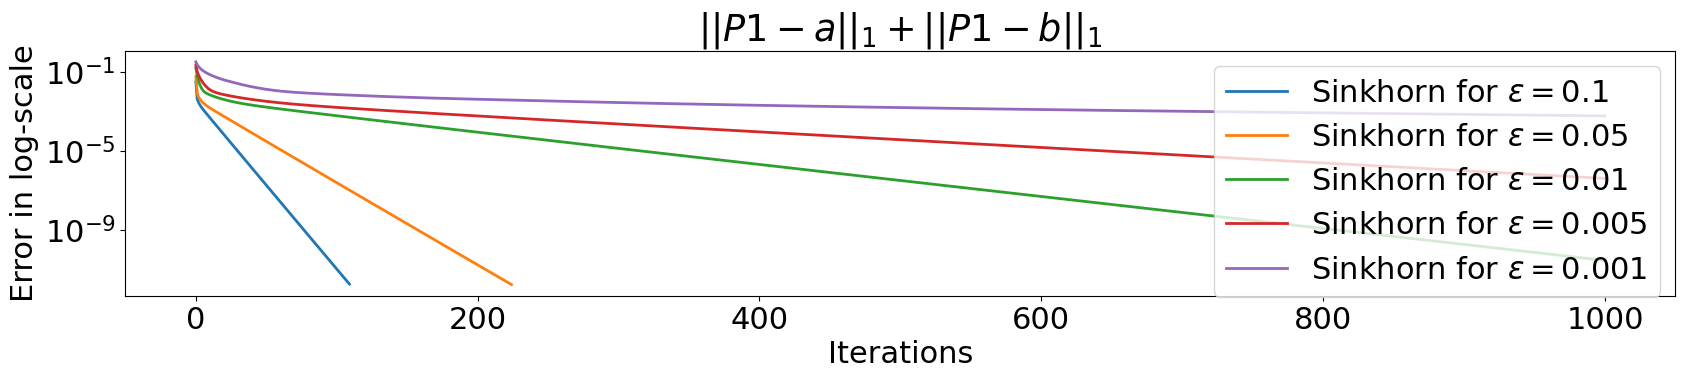

In [22]:
plt.rcParams.update({'font.size': 22})

plt.figure( figsize = (20,7) )

plt.subplot(2,1,1),
plt.title( "$||P1 -a||_1+||P1 -b||_1$" )
for i in range( len(results_Sinkhorn) ):
  error=np.asarray( results_Sinkhorn[i]['error_a'] )+np.asarray( results_Sinkhorn[i]['error_b'] )
  plt.plot( error,label = 'Sinkhorn for $\epsilon=$'+ str(epsilons[i]), linewidth = 2 )
plt.yscale( 'log' )
plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Error in log-scale")

plt.show()


#### Spectral plot

In [23]:
Hessians_sinkhorn = []
for i in range(len(epsilons)):
    u  = np.exp((results_Sinkhorn[i]['potential_f'])/epsilons[i])  
    v  = np.exp((results_Sinkhorn[i]['potential_g'])/epsilons[i])
    K  = np.exp(-C/epsilons[i])
    r1 = u[:,None]*np.dot(K,v)[:,None] 
    r2 = v[:,None]*np.dot(K.T,u)[:,None]                                
    P  = u[:,None]*np.exp(-C/epsilons[i])*v[None,:]
    A  = np.diag( np.array(r1.reshape(r1.shape[0],)) )
    B  = P       
    C_ = P.T
    D  = np.diag( np.array(r2.reshape(r2.shape[0],)) )
    result = np.vstack( ( np.hstack((A,B)), np.hstack((C_,D)) ) )    
    Hessians_sinkhorn.append(result)

In [24]:
                                                                                                                                                                                                                                                                                                                                                            
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    diag   = 1/np.sqrt(np.diag( Hessians_sinkhorn[i] ).flatten())
    result = diag[:,None]*Hessians_sinkhorn[i]*diag[None,:]
    ev = spectral_decomposition( result )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=0.1


List of smallest eigenvalues:  [4.46360529e-16 9.25797263e-02 1.01062875e-01 2.70738661e-01
 3.23314694e-01 5.00338560e-01 5.08021851e-01 6.56911422e-01
 6.98637358e-01 7.99707848e-01]
List of largest  eigenvalues:  [1.20029215 1.30136264 1.34308858 1.49197815 1.49966144 1.67668531
 1.72926134 1.89893712 1.90742027 2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [1.50044625e-16 4.64399194e-02 5.08333883e-02 1.51439431e-01
 1.78363169e-01 3.04058582e-01 3.07099041e-01 4.28085186e-01
 4.69695068e-01 5.75400499e-01]
List of largest  eigenvalues:  [1.4245995  1.53030493 1.57191481 1.69290096 1.69594142 1.82163683
 1.84856057 1.94916661 1.95356008 2.        ]

Spectral statistics of Hessian for epsilon=0.01
List of smallest eigenvalues:  [-8.54686091e-17  9.22148283e-03  1.10310574e-02  3.38742728e-02
  4.03713477e-02  7.41064732e-02  7.43911301e-02  1.10346031e-01
  1.25299746e-01  1.65593328e-01]
List of largest  eigenvalues:  [1.83440667 1.8747

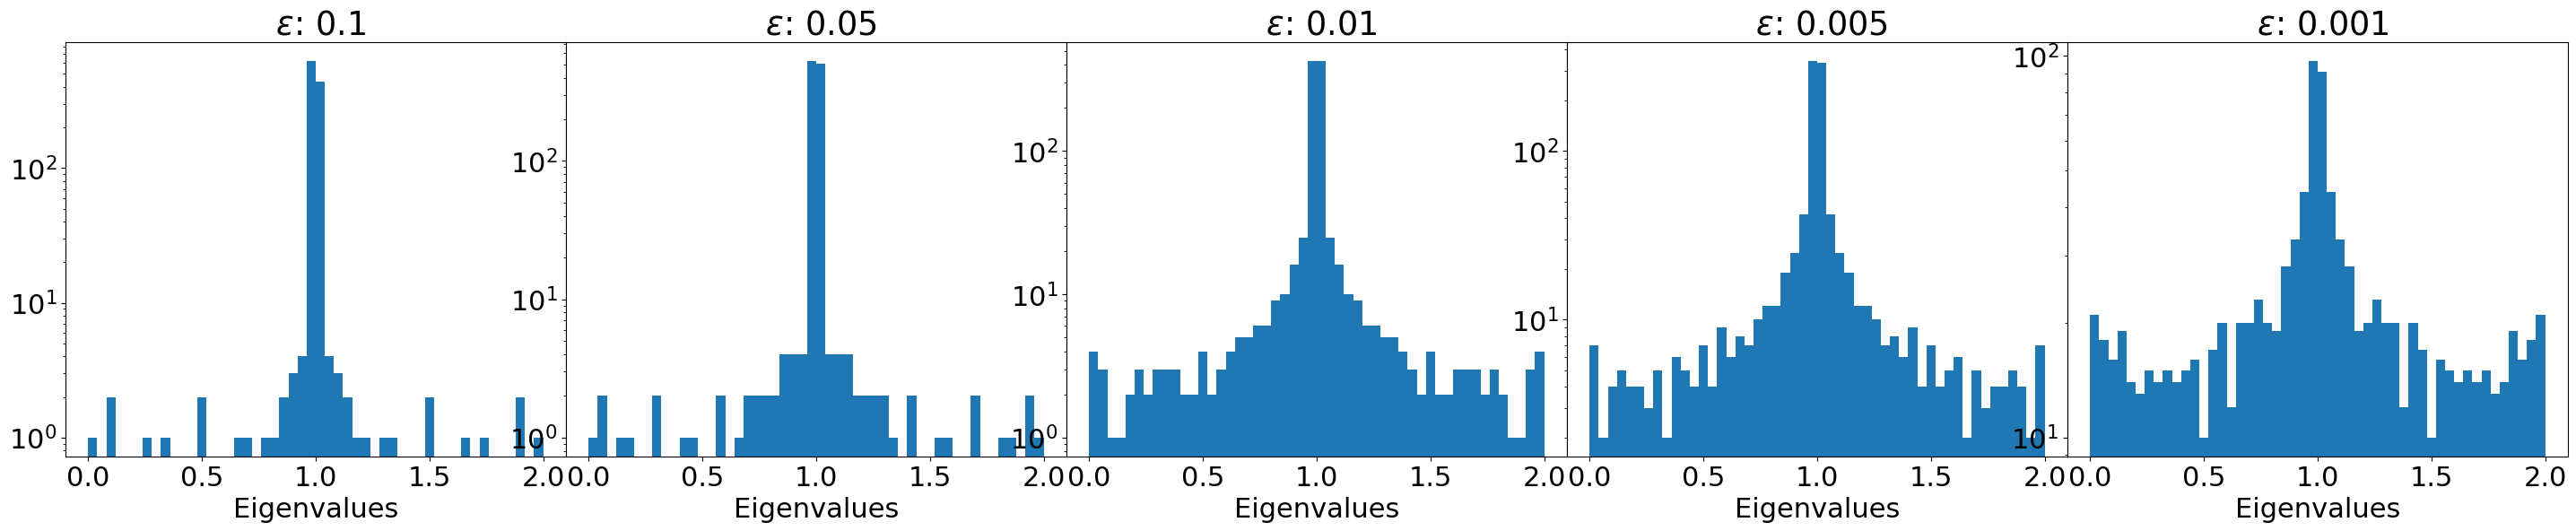

In [25]:
fig,ax = plt.subplots(figsize = (36,6),nrows = 1, ncols = len(epsilons), sharey = False)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    # ax[i].set_ylim(ymin = 0)
    # ax[i].set_ylim(bottom = 1e-1)
    ax[i].set_yscale( "log" )       
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

##### Spectral plots with preconditioning

In [26]:
num_eigs = [ 50, 100, 200, 400, 800, 1098 ]
preconditioned_Hessians = {}
for numeigs  in  range(len(num_eigs)):
    preconditioned_Hessians[num_eigs[numeigs]] = []
    for i in  range(len(epsilons)):
        diag   = 1/np.sqrt(np.diag( Hessians_logsinkhorn[i] ).flatten())
        result = diag[:,None]*Hessians_logsinkhorn[i]*diag[None,:]
        null_vector, precond_vectors = build_preconditioners( num_eigs[numeigs], result, ansatz=False )
        # vector = null_vector
        # vector = vector/diag
        # vector = vector/np.linalg.norm( vector )
        # vector = vector.reshape( ( len( vector ), 1) )
        # result = result + np.dot( vector, vector.T )
        y_ = np.array( precond_vectors ).T # Matrix of size n by k
        # Compute eigenvalues
        Ay = np.dot( result, y_ )
        eigenvalues = np.sum( y_ * Ay, axis=0 )
        # Compute P_matrix = id + y*diag(values)*y.T
        values = ( 1/np.sqrt(eigenvalues)-1 )    # Vector of size k
        z = y_*values[None,:]
        B = np.dot( Ay, z.T )
        C_ = z @ np.dot( y_.T, Ay ) @ z.T
        result = result + B + B.T + C_
        preconditioned_Hessians[num_eigs[numeigs]].append( result )

In [27]:
eigs = {}
for numeigs in  range(len(num_eigs)):
    eigs[num_eigs[numeigs]] = []
    for i in range(len(epsilons)):
        eps = epsilons[i]
        print("Spectral statistics of Hessian for epsilon="+str(eps))
        ev = spectral_decomposition( preconditioned_Hessians[num_eigs[numeigs]][i])
        eigs[num_eigs[numeigs]].append(ev[0])
        print("")


Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [0.         0.9838805  0.98504711 0.99071518 0.99131068 0.99179706
 0.99252702 0.99342908 0.99381788 0.99457773]
List of largest  eigenvalues:  [1.00542227 1.00618212 1.00657092 1.00747298 1.00820294 1.00868932
 1.00928482 1.01495289 1.0161195  2.        ]

Spectral statistics of Hessian for epsilon=0.05
List of smallest eigenvalues:  [-1.66533454e-16  9.08702918e-01  9.15273795e-01  9.34797640e-01
  9.41459512e-01  9.43477901e-01  9.45390346e-01  9.60903013e-01
  9.61400694e-01  9.63388176e-01]
List of largest  eigenvalues:  [1.03661182 1.03859931 1.03909699 1.05460965 1.0565221  1.05854049
 1.06520236 1.08472621 1.09129708 2.        ]

Spectral statistics of Hessian for epsilon=0.01
List of smallest eigenvalues:  [-6.35343292e-16  4.25987138e-01  4.44068063e-01  4.58214233e-01
  4.81551884e-01  4.95155865e-01  5.01631761e-01  5.07457676e-01
  5.32359915e-01  5.52365127e-01]
List of largest  eigenvalues:  [1

In [28]:
plt.rcParams.update({'font.size': 100})
fig,ax = plt.subplots(figsize = (120,130), nrows = len(num_eigs), ncols = len(epsilons), sharey = True, sharex = False)
plt.subplots_adjust(wspace=0,hspace=0.3)
p = np.log10(0.5)   
for numeigs in range(len(num_eigs)):
    for i in range(len(epsilons)):
        ax[numeigs][i].hist( eigs[num_eigs[numeigs]][i],50, rwidth = 0.9)
        ax[numeigs][i].set_title( " k = "+str(num_eigs[numeigs])+", $\epsilon$ = " +str(epsilons[i])+ "" )
        ax[numeigs][i].set_ylim(ymin = 10**p)
        ax[numeigs][i].set_yscale( "log" )  
                                    # ax[numeigs][i].set_xticks([0,1,2])
        # if numeigs == len(num_eigs):
        
        #     ax[numeigs][i].set_xlabel("Eigenvalues")
        #     ax[numeigs][i].set_xticks([0,1,2])   
ax[len(num_eigs)-1][len(epsilons)-1].set_xticks([0,1,2])   
plt.savefig("Spectralplot_images/PreconditionedHistograms_Sinkhorn.pdf",format = 'pdf',bbox_inches="tight")
plt.show()

### Damped Newton without preconditioning

In [30]:
rho = 0.95
c = 0.05
DampedNewtonP = []
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
#epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
epsilons = [ 0.1 , 0.05 , 0.01, 0.005,  0.001]
#Cost matrix
C = distmat(x,y)
for eps in epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    

    # a and b
    a = normalize(np.ones(N[0]))
    a = a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b = b.reshape(b.shape[0],-1)

    #Epsilon 

    # epsilon = .05

    #Kernel
    K = np.exp(-C/eps)

    f,g = 0*a,0*b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start = time.time()
    Optimizer = computational_OT.DampedNewton(K,a,b,f,g,eps,rho,c)
    out=Optimizer._update(maxiter=50, debug=True)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
    
    DampedNewtonP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))
    print( " |- Recording (unstabilized) Hessian \n")

    mat  = -eps*Optimizer.Hessian
    Hessians_DampedNewton.append( mat )

Damped Newton for epsilon=0.1:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.05:
Doing for ( 500 600 ).
 |- Iterating
Terminating after iteration:  13
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.01:
Doing for ( 500 600 ).
 |- Iterating
Inverse does not exist at epsilon: 0.01
 |- Computing P


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

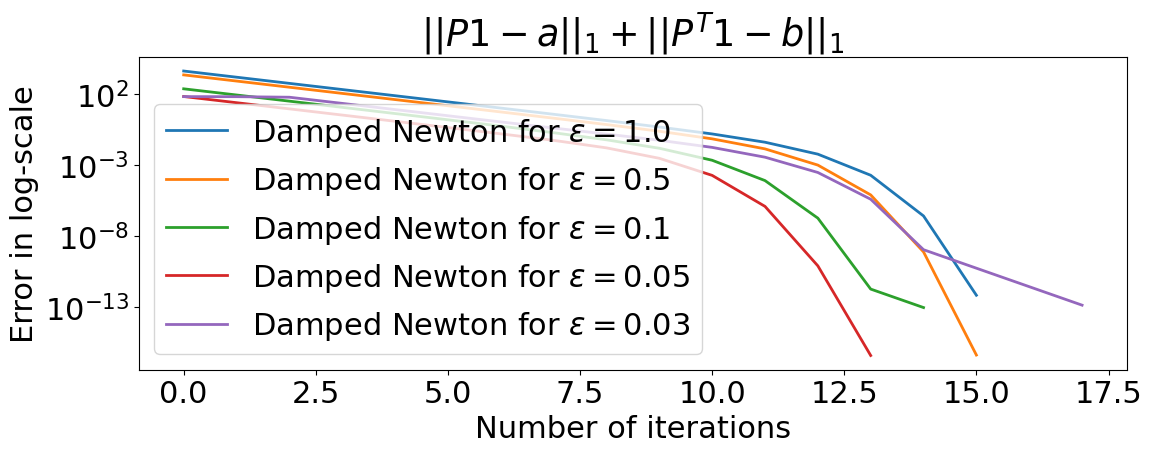

In [ ]:
plt.rcParams({'fontsze':22})
plt.figure(figsize = (12,5))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i]['error_a'])+np.asarray(results_DampedNewton[i]['error_b'])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.tight_layout()
plt.show()



#### Spectral plots 

In [ ]:
eigs = []
eigvecs = []
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    diag   = 1/np.sqrt(np.diag( Hessians_DampedNewton[i] ).flatten())
    result = diag[:,None]*Hessians_DampedNewton[i]*diag[None,:]
    ev = spectral_decomposition( result )
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [-1.49186219e-16  6.48489658e-01  6.64969762e-01  9.15826360e-01
  9.43785410e-01  9.89048070e-01  9.89607244e-01  9.90276223e-01
  9.98504570e-01  9.98616669e-01]
List of largest  eigenvalues:  [1.00138333 1.00149543 1.00972378 1.01039276 1.01095193 1.05621459
 1.08417364 1.33503024 1.35151034 2.        ]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [-6.08020578e-16  4.23862028e-01  4.45177314e-01  7.60246766e-01
  8.26259254e-01  9.41341914e-01  9.43222244e-01  9.68995164e-01
  9.87868093e-01  9.88516659e-01]
List of largest  eigenvalues:  [1.01148334 1.01213191 1.03100484 1.05677776 1.05865809 1.17374075
 1.23975323 1.55482269 1.57613797 2.        ]

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [-2.59532589e-16  9.25797263e-02  1.01062875e-01  2.70738661e-01
  3.23314694e-01  5.00338560e-01  5.08021851e-01  6.56911422e-01
  6.98637358e-01  

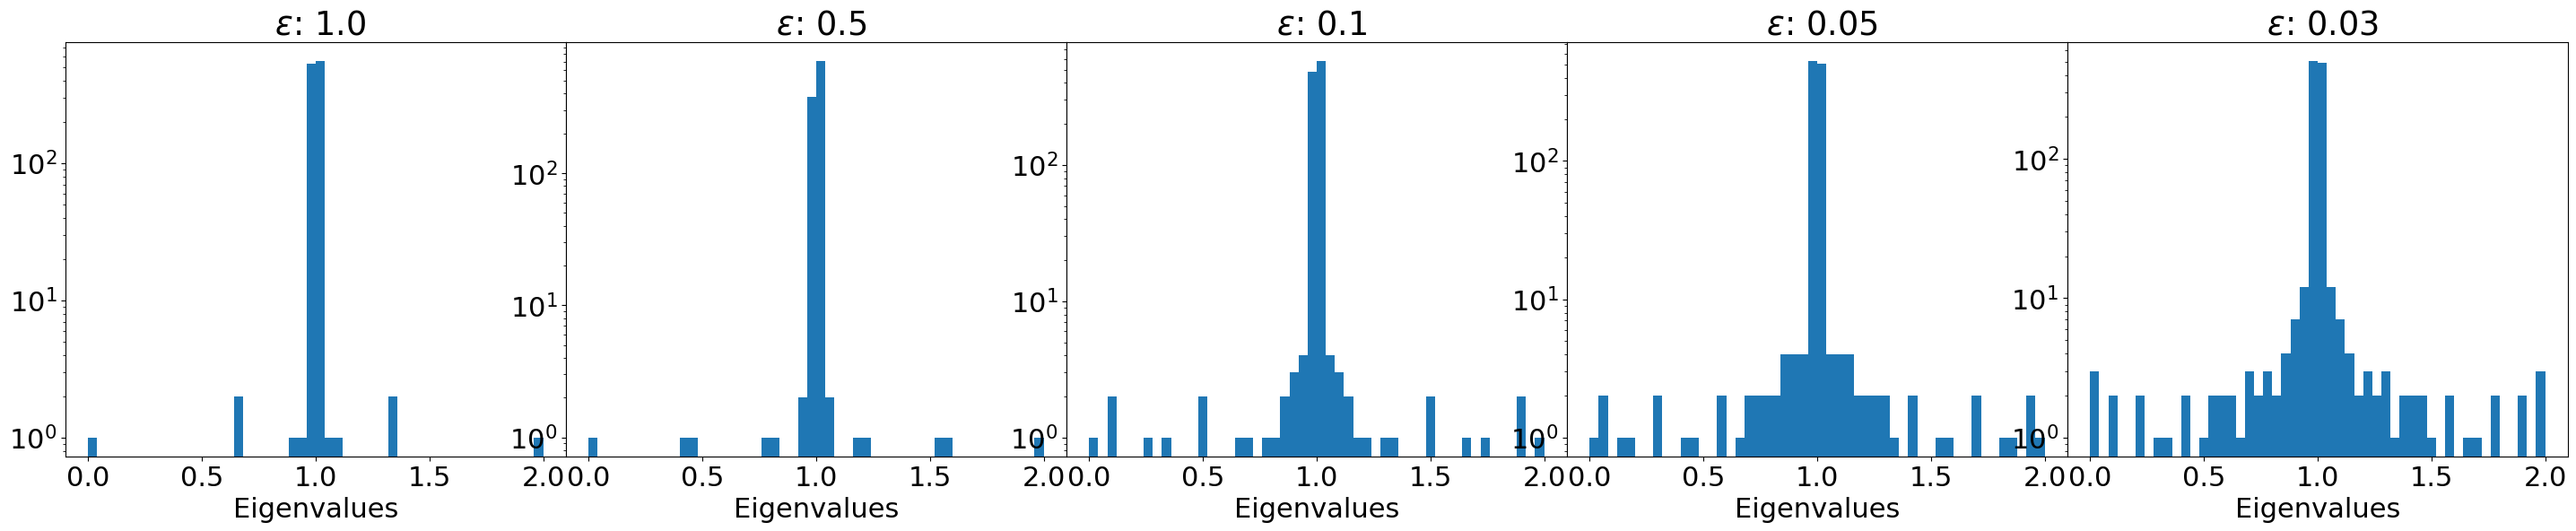

In [ ]:
fig,ax = plt.subplots(figsize = (36,6),nrows = 1, ncols = len(epsilons), sharey = False)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    # ax[i].set_ylim(ymin = 0)
    # ax[i].set_ylim(bottom = 1e-1)
    ax[i].set_yscale( "log" )       
plt.subplots_adjust(wspace=0,hspace=0)
plt.show()

##### Spectral plots with preconditioning

In [ ]:
num_eigs = [ 50, 100, 200, 400, 800, 1098 ]
preconditioned_Hessians = {}
for numeigs  in  range(len(num_eigs)):
    preconditioned_Hessians[num_eigs[numeigs]] = []
    for i in  range(len(epsilons)):
        diag   = 1/np.sqrt(np.diag( Hessians_logsinkhorn[i] ).flatten())
        result = diag[:,None]*Hessians_logsinkhorn[i]*diag[None,:]
        null_vector, precond_vectors = build_preconditioners( num_eigs[numeigs], result, ansatz=False )
        # vector = null_vector
        # vector = vector/diag
        # vector = vector/np.linalg.norm( vector )
        # vector = vector.reshape( ( len( vector ), 1) )
        # result = result + np.dot( vector, vector.T )
        y_ = np.array( precond_vectors ).T # Matrix of size n by k
        # Compute eigenvalues
        Ay = np.dot( result, y_ )
        eigenvalues = np.sum( y_ * Ay, axis=0 )
        # Compute P_matrix = id + y*diag(values)*y.T
        values = ( 1/np.sqrt(eigenvalues)-1 )    # Vector of size k
        z = y_*values[None,:]
        B = np.dot( Ay, z.T )
        C_ = z @ np.dot( y_.T, Ay ) @ z.T
        result = result + B + B.T + C_
        preconditioned_Hessians[num_eigs[numeigs]].append( result )

In [ ]:
eigs = {}
for numeigs in  range(len(num_eigs)):
    eigs[num_eigs[numeigs]] = []
    for i in range(len(epsilons)):
        eps = epsilons[i]
        print("Spectral statistics of Hessian for epsilon="+str(eps))
        ev = spectral_decomposition( preconditioned_Hessians[num_eigs[numeigs]][i])
        eigs[num_eigs[numeigs]].append(ev[0])
        print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [0.9958762  0.99999956 0.99999974 0.9999999  0.9999999  0.99999991
 0.99999997 0.99999997 0.99999999 0.99999999]
List of largest  eigenvalues:  [1.00000001 1.00000001 1.00000003 1.00000003 1.00000009 1.0000001
 1.0000001  1.00000026 1.00000044 2.0041238 ]

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [0.9958762  0.99996636 0.99998885 0.99999154 0.99999216 0.99999561
 0.9999957  0.99999603 0.99999879 0.99999889]
List of largest  eigenvalues:  [1.00000111 1.00000121 1.00000397 1.0000043  1.00000439 1.00000784
 1.00000846 1.00001115 1.00003364 2.0041238 ]

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [0.9838805  0.98504711 0.99071518 0.99131068 0.99179706 0.99252702
 0.99342908 0.99381788 0.99457773 0.99583429]
List of largest  eigenvalues:  [1.00542227 1.00618212 1.00657092 1.00747298 1.00820294 1.00868932
 1.00928482 1.01495289 1.0161195  2.0041

In [ ]:
plt.rcParams.update({'font.size': 100})
fig,ax = plt.subplots(figsize = (120,130), nrows = len(num_eigs), ncols = len(epsilons), sharey = True, sharex = False)
plt.subplots_adjust(wspace=0,hspace=0.3)
p = np.log10(0.5)   
for numeigs in range(len(num_eigs)):
    for i in range(len(epsilons)):
        ax[numeigs][i].hist( eigs[num_eigs[numeigs]][i],50, rwidth = 0.9)
        ax[numeigs][i].set_title( " k = "+str(num_eigs[numeigs])+", $\epsilon$ = " +str(epsilons[i])+ "" )
        ax[numeigs][i].set_ylim(ymin = 10**p)
        ax[numeigs][i].set_yscale( "log" )  
                                    # ax[numeigs][i].set_xticks([0,1,2])
        # if numeigs == len(num_eigs):
        
        #     ax[numeigs][i].set_xlabel("Eigenvalues")
        #     ax[numeigs][i].set_xticks([0,1,2])   
ax[len(num_eigs)-1][len(epsilons)-1].set_xticks([0,1,2])    
plt.savefig("Spectralplot_images/PreconditionedHistograms_DampedNewtonwithoutprecond.pdf",format = 'pdf',,bbox_inches="tight")
plt.subplots_adjust(wspace=0,hspace=0.1)
plt.show()